# 2.8 Statistical Considerations for geoscientific Data and Noise

Statistical properties of geoscientific data

In [5]:
# Import modules for seismic data and feature extraction

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats as st
import scipy.signal as sig

# time series feature extraction python toolbox:
# import tsfresh




## 1. Statistical Features

::warning:: this might be replaced with slides.

s
Let be $P(z)$ the distribution of the data $z$.

### The mean
<div>
<img src="mean.png" alt="mean" height=300  />
</div>

Image taken from this [blog](!https://gregorygundersen.com/blog/2020/04/11/moments).

The mean is the sum of the values divided by the number of data points. It is the first raw moment of a distribution. 
$\mu = \int_{-\infty}^\infty zP(z)dz$, where z is the ground motion value (bin) and $P(z)$ is the distribution of the data.

### The Variance
 <div>
<img src="variance.png" alt="variance" height=200  />
</div>

The variance is the second *centralized* moment. *Centralized* means that the distribution is shifted around the mean. It calculates how spread out is a distribution.

$\sigma^2 = \int_{-\infty}^\infty (z-\mu)^2P(z)dz$

The standard deviation is the square root of the variance, $\sigma$. A high variance indicates a wide distribution.

### The skewness

Skewness is the third *standardized* moment. The *standardized* moment is scaled by the standard deviation. It measures the relative size of the two tails of the distribution.


$m_3= \int_{-\infty}^\infty \frac{(z - \mu)^3}{\sigma^3}P(z)dz$

With the cubic exponent, it is possible that the skewness is negative.

 <div>
<img src="skewness.png" alt="skewness" height=200  />
</div>

Image taken from this [blog](!https://gregorygundersen.com/blog/2020/04/11/moments).

A positively skewed distribution is one where most of the weight is at the end of the distribution. A negatively skewed distribution is one where most of the weight is at the beginning of the distribution.


### Kurtosis

Kurtosis measures the combined size of the two tails relative to the whole distribution. It is the fourth centralized and standardized moment.

$m_4= \int_{-\infty}^\infty (\frac{z-\mu}{\sigma})^4P(z)dz$

 <div>
<img src="kurtosis.png" alt="kurtosis" height=200  />
</div>
The laplace, normal, and uniform distributions have a mean of 0 and a variance of 1. But their kurtosis is 3, 0, and -1.2.


Python functions to calculate the moments might be:

In [3]:
def raw_moment(X, k, c=0):
    return ((X - c)**k).mean()

def central_moment(X, k):
    return raw_moment(X=X, k=k, c=X.mean())

## 2. Toy problem: synthetic data and noise


Here we will construct a time series with 1 ricker wavelet as a source and synthetic noise

We will analyze their statistical properties and compare the distributions. Present this as a binary classification problem.

In [37]:
fs = 100. # sampling rate
twin = 50. # window length
t = np.linspace(0,twin,int(twin*fs)) #points = 100

#### Event Signal

We will create an event signal as a Ricker wavelet of specified width, 4 seconds in time.

Text(0.5, 0, 'Time in s')

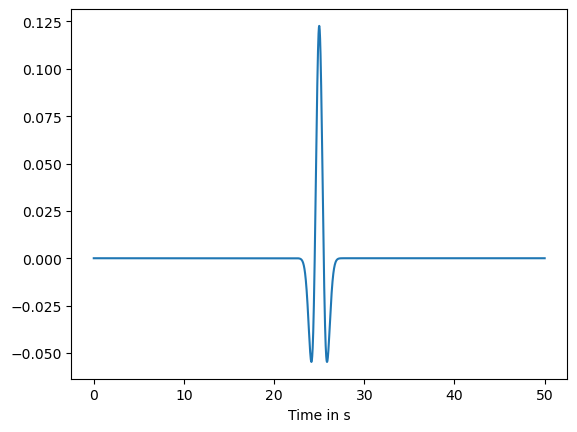

In [71]:
a = 50 # proportional to the width of the wavelet, about a factor of 10
sa = sig.ricker(int(a*fs), a)
# plate the signal in the middle of the time series
s = np.concatenate((np.zeros(len(t)//2-len(sa)//2),sa,np.zeros(len(t)//2-len(sa)//2)))

# plot the signal
plt.plot(t,s)
plt.xlabel('Time in s')


The Ricker wavelet is a smooth function with a signal in a specific frequency band. Let's plot it's absolute Fourier amplitude spectrum.

In [72]:
from scipy.fftpack import fft, fftfreq, next_fast_len

## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(len(s)) # this will be an even number

freqVec = fftfreq(Nfft, d=1/fs)[:Nfft//2]
Zhat = fft(s,n=Nfft)

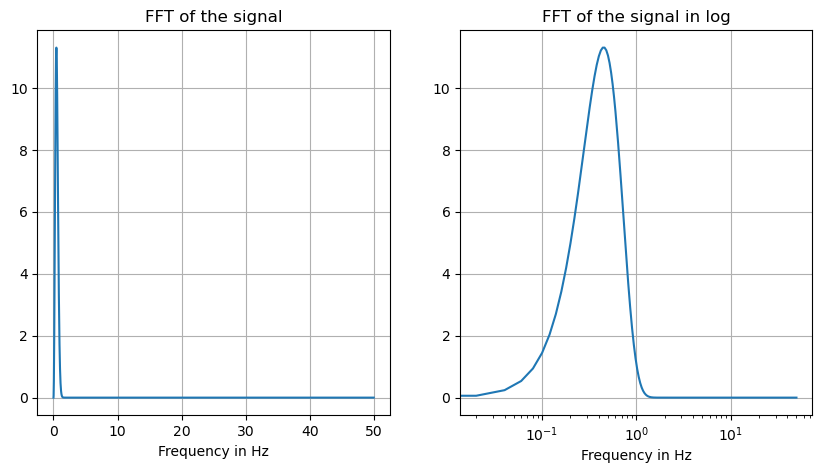

In [73]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(freqVec, np.abs(Zhat[:Nfft//2]))
ax[0].grid()
ax[0].set_title('FFT of the signal')
ax[0].set_xlabel('Frequency in Hz')
ax[1].plot(freqVec, np.abs(Zhat[:Nfft//2]))
ax[1].set_xscale('log')
ax[1].set_xlabel('Frequency in Hz')
ax[1].set_title('FFT of the signal in log')
ax[1].grid()

What does the event data distribution looks like?

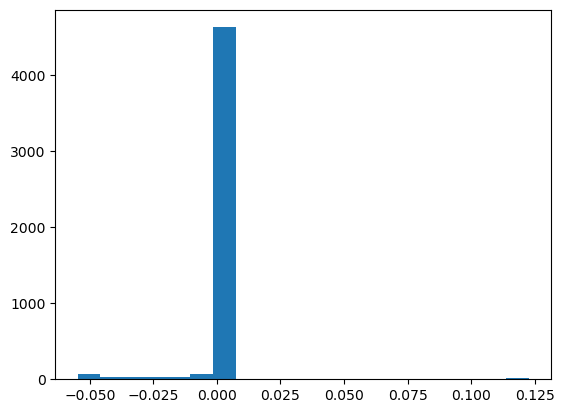

In [74]:
plt.hist(sa,bins=20);

We created a pure signal not contaminated by noise. Let's create a *noise* time series to add on the *signal* time series.

Synthetic noise may take several form.

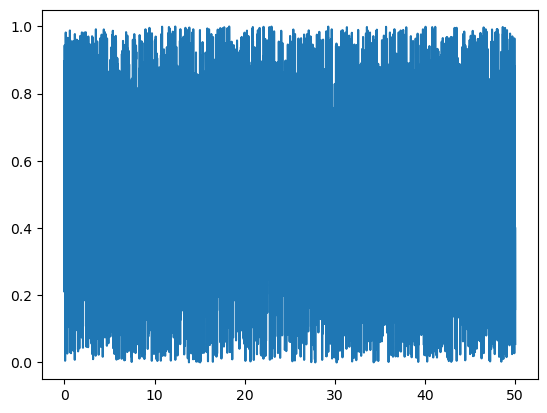

In [77]:
noise = np.random.rand(len(s))
plt.plot(t,noise)

Check the Fourier amplitude spectrum of the noise

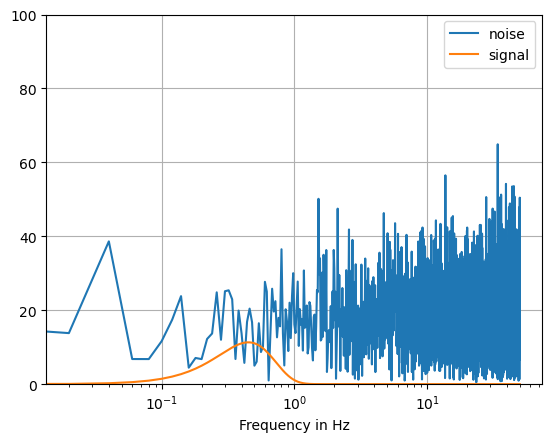

In [79]:
nhat = fft(noise,n=Nfft)
plt.plot(freqVec, np.abs(nhat[:Nfft//2]))
plt.plot(freqVec, np.abs(Zhat[:Nfft//2]))
plt.xscale('log')
plt.legend(['noise','signal'])
plt.xlabel('Frequency in Hz')
plt.ylim([0,100])   
plt.grid()

OK, they look very different in the spectral domain!
Let's add noise to the data and plot it.

We will tune a signal to noise ratio to multiply the noise level relative to the signal level. We define this as the max absolute amplitude of the signal, divided by the max absolute amplitude of the noise

In [93]:
SNR = 100 # signal to noise ratio

Now normalize both noise and signal amplitudes.

In [84]:
s /= np.max(np.abs(s)) # normalize the signal
noise /= np.max(np.abs(noise)) # normalize the noise    

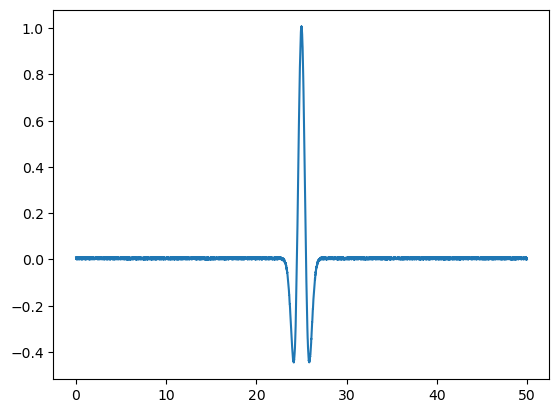

In [94]:
noisy_signal = s + noise/SNR
plt.plot(t,noisy_signal)
plt.grid()
plt.title('Noisy signal')
plt.xlabel('Time in s')

Noise may have different frequency content, or *color*. We can construct a time series of noise based on its Fourier amplitude spectrum.

In [131]:
from scipy.fftpack import ifft
# random phase
NN = 2*np.pi*np.random.uniform(-1,1,Nfft//2)-np.pi
newnoiseF=np.zeros(Nfft,dtype=np.complex_)
for i in range(Nfft//2):
    newnoiseF[i] = np.exp(1j*NN[i])
    newnoiseF[-i] = np.conj(newnoiseF[i])
newnoiseF[0] = 0
noise = ifft(newnoiseF).real

In [132]:
noise

array([-0.00142572,  0.01791888, -0.02187551, ..., -0.00307819,
        0.01056925, -0.0061892 ])

Text(0.5, 1.0, 'Noise with random phase and white spectrum')

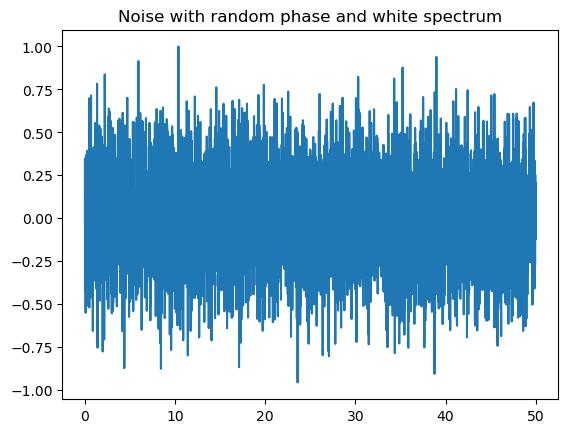

In [133]:
noise/=np.max(np.abs(noise)) # normalize the noise  
plt.plot(t,noise)
plt.title('Noise with random phase and white spectrum')

Add the new noise and the signal (Ricker wavelet) and plot them in time and frequency domain

In [134]:
SNR=1

In [135]:
news = s+noise/SNR

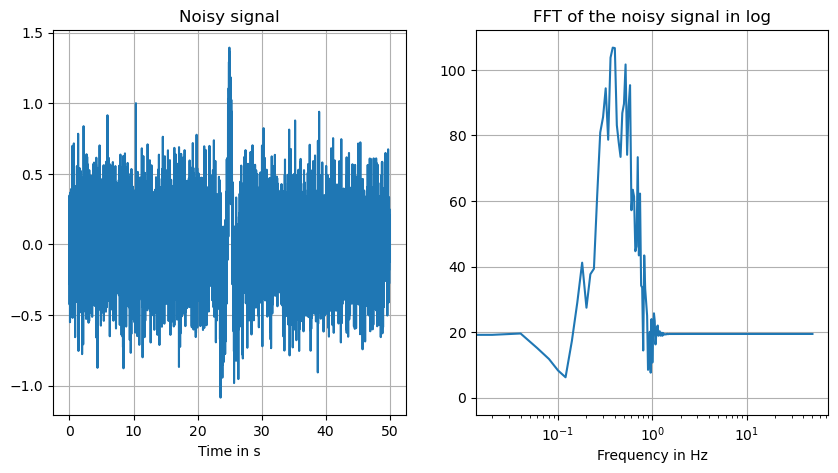

In [136]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(t,news)
ax[0].set_title('Noisy signal')
ax[0].set_xlabel('Time in s')
ax[0].grid()
ax[1].plot(freqVec, np.abs(fft(news,n=Nfft)[:Nfft//2]))
ax[1].set_xscale('log')
ax[1].grid()
ax[1].set_xlabel('Frequency in Hz')
ax[1].set_title('FFT of the noisy signal in log');

Let's compare the data distribution between the pure signal, the noise signal, and the combined signals.

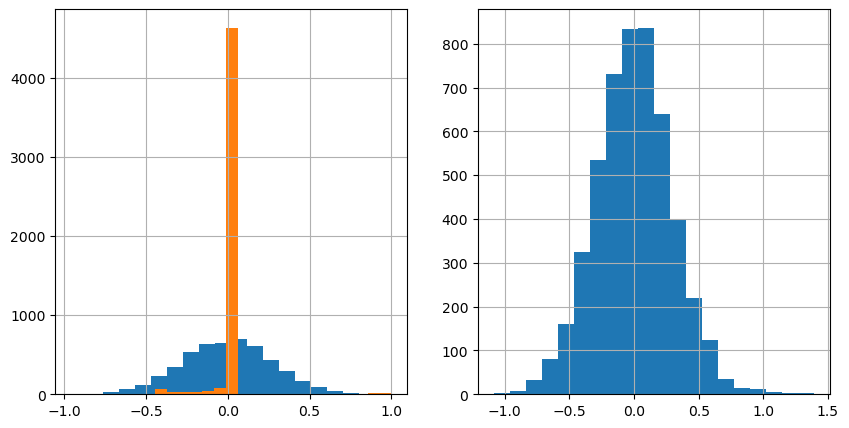

In [142]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].hist(noise,bins=20);ax[0].grid()
ax[0].hist(s,bins=20);
ax[1].hist(news,bins=20);ax[1].grid();


We can now calculate the mean, variance, skewness, and kurtosis of the data:


In [108]:
# enter answers here using the functions for the moment.
# the mean:
print(raw_moment(news,1))

# the variance:
print(central_moment(news,2))

# the skewness
print(central_moment(news,3)/central_moment(news,2)**(3/2))

# the kurtosis
print(central_moment(news,4)/central_moment(news,2)**2)



(0.00032309223696792985-0.006741190475628536j)
(0.01275254491330795-0.0004032489991986076j)
(3.880925910282197+1.131117825159448j)
(40.69745366849645-9.550902787570033j)


We can also use the numpy and scipy modules to get these values

In [137]:
print('the mean is %4.2f, the variance is %4.2f, the skewness is %4.2f, the kurtosis is %4.2f'
 %(np.mean(news),np.std(news)**2,scipy.stats.skew(news),scipy.stats.kurtosis(news,fisher=False)))

the mean is 0.00, the variance is 0.09, the skewness is 0.15, the kurtosis is 3.55


These values may mean nothing without some additional context. We can download seismic noise data to see if the earthquake waveforms are statistically different from the noise. For that, we will download the same length of data prior to the earthquake:

### Geological data sets

In [ ]:
# Load .csv data into a pandas dataframe

df = pd.read_csv('EarthRocGranites.csv')

# Remove any rows that are empty
df = df.dropna()

# Let's print out this data frame
print(df)



NameError: name 'pd' is not defined

In [ ]:
# Now, let's visualize the histograms of silica and magnesium

# Create a subplot with two histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the histograms for each column
axes[0].hist(df['SIO2(WT%)'], bins=60, color='black')
axes[0].set_xlabel('SiO$_2$, wt%')
axes[0].set_ylabel('Count')
axes[0].set_xlim([40, 100])

axes[1].hist(df['MGO(WT%)'], bins=100, color='black')
axes[1].set_xlabel('MgO, wt%')
axes[1].set_ylabel('Count')
# Note these xlims -> the data largely [but not completely!] sit between 0 and 10 wt%
axes[1].set_xlim([0, 10])

# Add spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# One more plot: let's look at a scatter of SiO2 vs. MgO
plt.scatter(df['SIO2(WT%)'], df['MGO(WT%)'], c='red', alpha=0.125)
ax = plt.gca()
ax.set_xlim([0,100])
ax.set_xlabel('SiO$_2$, wt%')
ax.set_ylim([0,100])
ax.set_ylabel('MgO, wt%')
ax.set_aspect('equal')

Now, let's generate *moments* for SiO$_2$



In [ ]:
# Let us first define the moment functions

def raw_moment(X, k, c=0):
    return ((X - c)**k).mean()

def central_moment(X, k):
    return raw_moment(X=X, k=k, c=X.mean())

# The mean:
print(f'The mean is: {raw_moment(df["SIO2(WT%)"], 1):4.2f}')

# Variance:
print(f'The variance is: {central_moment(df["SIO2(WT%)"], 2):4.2f}')

# Skewness:
skewness = central_moment(df["SIO2(WT%)"], 3) / central_moment(df["SIO2(WT%)"], 2) ** (3/2)
print(f'The skewness is: {skewness:4.2f}')

# Kurtosis
kurtosis_value = central_moment(df['SIO2(WT%)'], 4) / central_moment(df['SIO2(WT%)'], 2) ** 2
print(f'The kurtosis is: {kurtosis_value:4.2f}')

In [ ]:
# We can also just use pandas (or numpy or scipy):

print('The mean is: %4.2f, the variance is: %4.2f, the skewness is: %4.2f, and the kurtosis is: %4.2f' % (df['SIO2(WT%)'].mean(), df['SIO2(WT%)'].var(), df['SIO2(WT%)'].skew(), df['SIO2(WT%)'].kurtosis()))


## 3. Realistic problem: data- or physics-informed synthetic data and noise

In this case, we can create a time series that has the similar noise structure than the realistic noise.